In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from Models import probitModel, logisticModel
from util import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from imblearn.over_sampling import SMOTE

In [2]:
SEED = 1

data_folder = 'data'
df = pd.read_csv(os.path.join(data_folder,'mimiciv_traindata.csv'))
df.head()

,Fraction inspired oxygen_mean,Fraction inspired oxygen_min,Fraction inspired oxygen_max,Glucose_mean,Glucose_min,Glucose_max,Heart Rate_mean,Heart Rate_min,Heart Rate_max,Mean blood pressure_mean,...,Temperature_mean,Temperature_min,Temperature_max,Weight_mean,Weight_min,Weight_max,pH_mean,pH_min,pH_max,mortality
0,0.484615,0.4,0.6,155.181818,52.0,280.0,52.367347,35.0,93.0,87.096154,...,36.356349,35.200000,37.100000,81.419764,81.419764,81.419764,7.328750,7.19,7.40,1.0
1,0.600000,0.5,1.0,127.954545,85.0,177.0,72.660377,58.0,105.0,72.315789,...,36.786325,36.388889,37.055556,93.103510,91.807021,95.000000,7.377143,7.34,7.42,0.0
2,0.481250,0.4,0.8,145.625000,116.0,180.0,107.260000,96.0,118.0,86.462963,...,37.316239,36.611111,37.944444,67.500000,67.500000,67.500000,7.372000,7.29,7.45,0.0
3,0.400000,0.4,0.4,100.142857,77.0,154.0,57.250000,47.0,65.0,69.762712,...,NaN,NaN,NaN,80.403091,76.838485,86.000000,7.161250,6.00,7.36,1.0
4,0.566667,0.4,1.0,138.000000,116.0,155.0,84.015625,64.0,114.0,70.662162,...,36.148990,34.722222,37.666667,NaN,NaN,NaN,7.374444,7.27,7.42,1.0


mortality
0.0    0.749424
1.0    0.250576
Name: proportion, dtype: float64


<Axes: xlabel='mortality'>

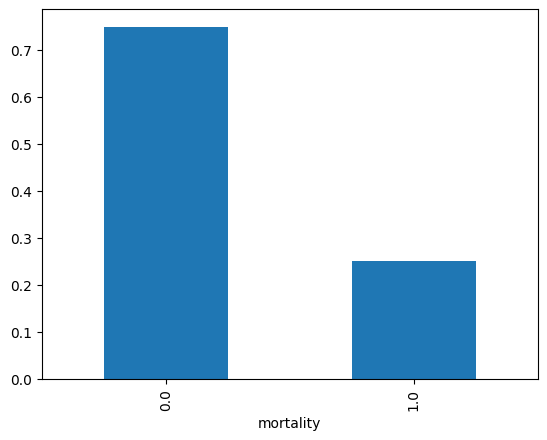

In [3]:
print(df.mortality.value_counts(normalize=True))
df.mortality.value_counts(normalize=True).plot(kind='bar')
#sns.countplot(x='mortality', data=df)

In [4]:
x = df.drop('mortality',axis=1)
y = df.mortality.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=SEED)

In [5]:
#scaler = RobustScaler(unit_variance=True)
scaler = QuantileTransformer(output_distribution='normal', ignore_implicit_zeros=False)
#scaler = PowerTransformer(method='yeo-johnson', standardize=True)

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

imp = KNNImputer(missing_values=np.nan, n_neighbors=10)#SimpleImputer(missing_values=np.nan, strategy='mean') #
x_train = imp.fit_transform(x_train)
x_test = imp.transform(x_test)

#smote = SMOTE(random_state = SEED)
#print('Original Dataset Shape:', np.unique(y_train, return_counts=True))
#x_train, y_train = smote.fit_resample(x_train, y_train)
#print('Resampled Dataset Shape:', np.unique(y_train, return_counts=True))
n_samples = x.shape[0]
_, (n_samples0, n_samples1) = np.unique(y, return_counts=True)
w0 =  n_samples1/n_samples #n_samples/(2*n_samples0) #
w1 =  n_samples0/n_samples#n_samples/(2*n_samples1) #
print(n_samples, n_samples0, n_samples1)
print(w0,w1)

5647 4232 1415
0.25057552682840445 0.7494244731715956


In [6]:
probit = probitModel(l2=0.05, w=w1)
res_dict = probit.fit(x_train, y_train, verbose=True)
result = res_dict['result']
loss_values = res_dict['loss']


Current loss: 0.5054010704941398
Current loss: 0.49390993063104116
Current loss: 0.4907383212659584
Current loss: 0.48966324300606934
Current loss: 0.4893822276147894
Current loss: 0.4892785021149938
Current loss: 0.4892475967865234
Current loss: 0.48923073134653255
Current loss: 0.48922558095216606
Current loss: 0.4892231858286399
Current loss: 0.48922250256665345
Current loss: 0.48922241551425055
Current loss: 0.489222384345218
Current loss: 0.48922237882216457
Current loss: 0.4892223777540755
Wald test summary:
+----+---------+-------------+-----------+---------+---------+
|    |   index |        coef |   std err |       z |   P>|z| |
|----+---------+-------------+-----------+---------+---------|
|  0 |      21 |  0.10835    |    0.0294 |  3.6836 |  0.0002 |
|  1 |      33 | -0.0873272  |    0.0244 | -3.5827 |  0.0003 |
|  2 |      19 | -0.0515003  |    0.0182 | -2.8357 |  0.0046 |
|  3 |       8 |  0.09936    |    0.0374 |  2.6562 |  0.0079 |
|  4 |      25 | -0.0797404  |    0.034

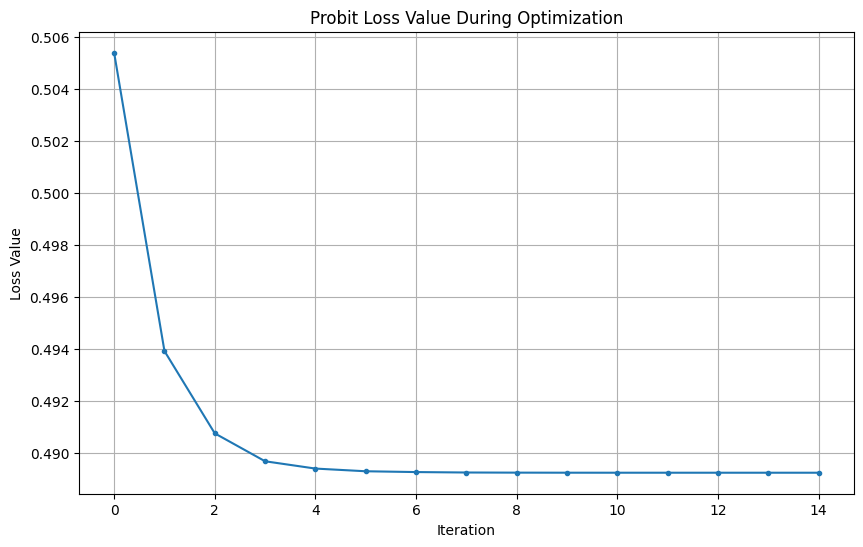

In [7]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Probit Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.634
Precision: 0.384
Recall: 0.608
F1 Score: 0.471
AUC score: 0.672 



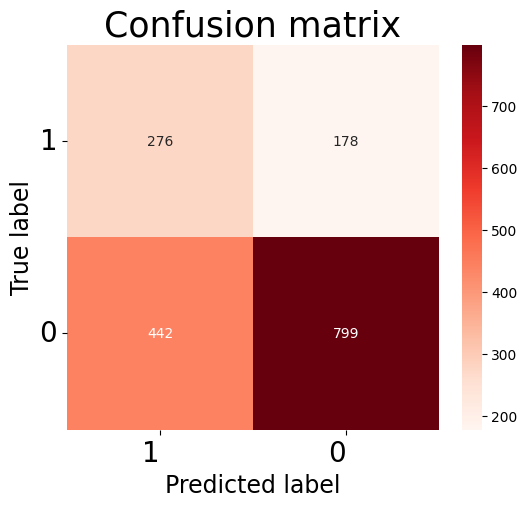

In [8]:
y_prob = probit.predict_proba(x_test)[:,1]
y_label = probit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

Optimal threshold is 0.4848, at f1 score of 0.4745


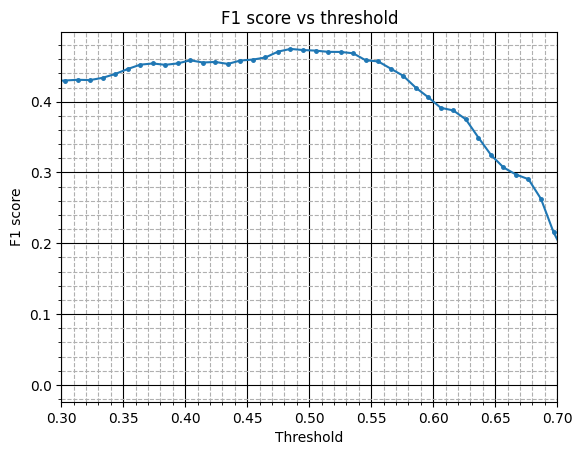

In [9]:
plot_f1_vs_thr(y_test, y_prob)

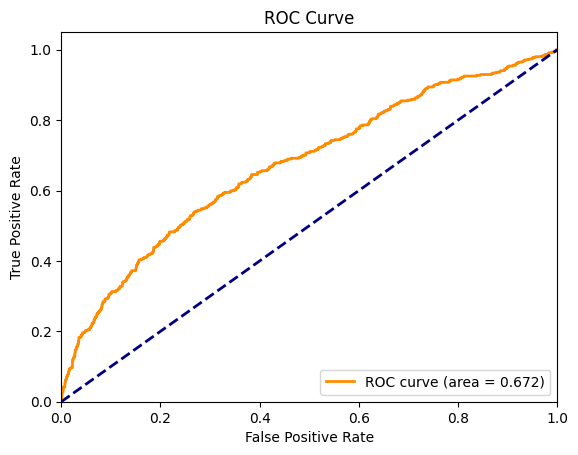

In [10]:
plot_roc(y_test, y_prob)

In [11]:
logit = logisticModel(l2=0.0, w=0.5)
res_dict = logit.fit(x_train, y_train, verbose=True)
result = res_dict['result']
loss_values = res_dict['loss']


Current loss: 0.613444879359103
Current loss: 0.5546365342694929
Current loss: 0.5217006256678669
Current loss: 0.5160438352387304
Current loss: 0.5140865650550092
Current loss: 0.5125599153480508
Current loss: 0.5113179950013972
Current loss: 0.5104431878297493
Current loss: 0.5097227454625158
Current loss: 0.509153217747352
Current loss: 0.5087928382378161
Current loss: 0.5085580638799083
Current loss: 0.5083363578475983
Current loss: 0.5080806445999478
Current loss: 0.5078227655298465
Current loss: 0.5076054510452719
Current loss: 0.5074269613791706
Current loss: 0.5072649150385453
Current loss: 0.5071173821298227
Current loss: 0.5069921093963131
Current loss: 0.5068915360600221
Current loss: 0.5068121963678253
Current loss: 0.5067502526327596
Current loss: 0.5066986993139257
Current loss: 0.5066484392472818
Current loss: 0.5065987070309371
Current loss: 0.506559156422712
Current loss: 0.5065340209466208
Current loss: 0.5065159714837393
Current loss: 0.5064964132348224
Current loss:

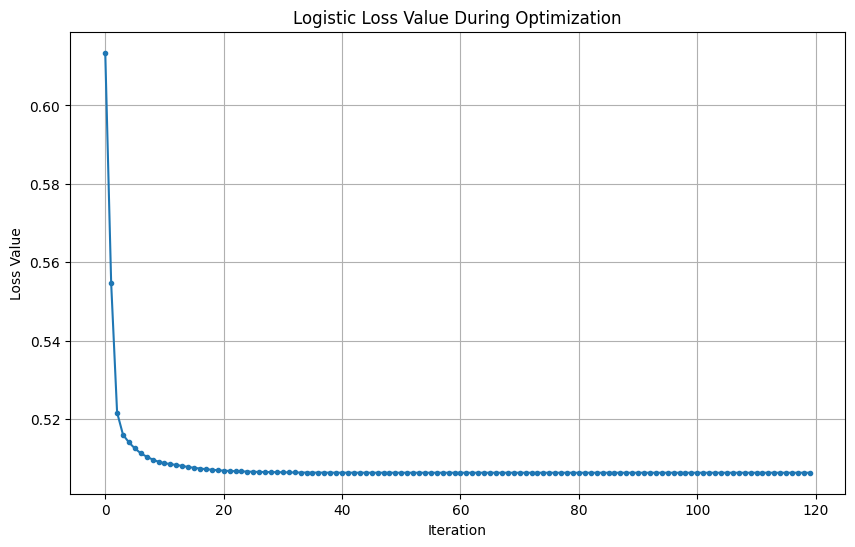

In [12]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(loss_values, marker='.', linestyle='-')
plt.title('Logistic Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

Accuracy: 0.747
Precision: 0.644
Recall: 0.128
F1 Score: 0.213
AUC score: 0.676 



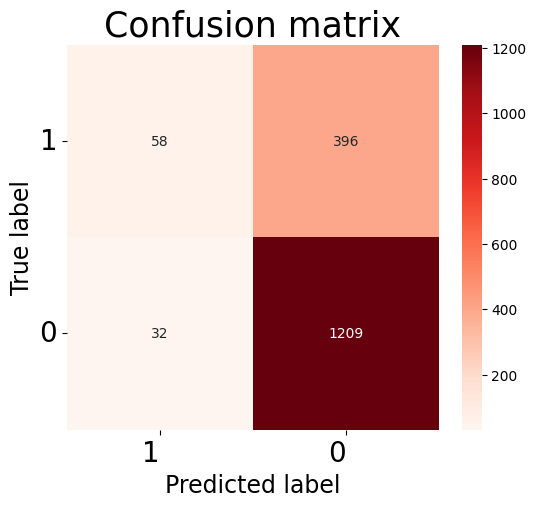

In [13]:
y_prob = logit.predict_proba(x_test)[:,1]
y_label = logit.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

Optimal threshold is 0.2424, at f1 score of 0.4748


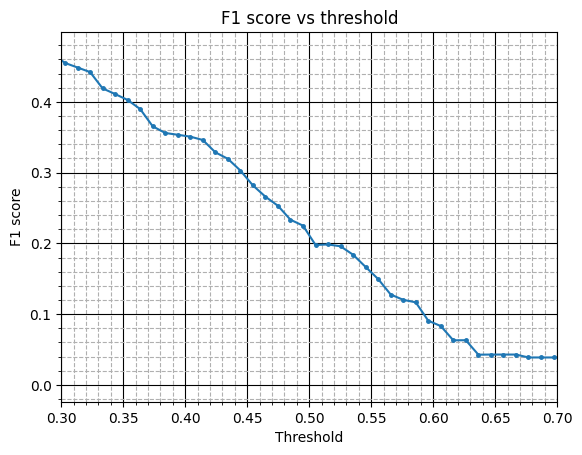

In [14]:
plot_f1_vs_thr(y_test, y_prob)

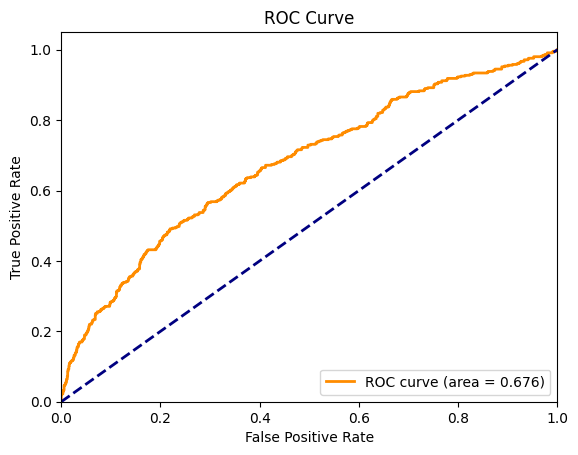

In [15]:
plot_roc(y_test, y_prob)

In [16]:
import statsmodels.api as sm 
x_train_sm = sm.add_constant(x_train.copy())
log_reg = sm.Logit(y_train, x_train_sm).fit(method='bfgs',maxiter=1000,tol=1e-5)
print(log_reg.summary()) 

Optimization terminated successfully.
         Current function value: 0.506360
         Iterations: 120
         Function evaluations: 121
         Gradient evaluations: 121
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3952
Model:                          Logit   Df Residuals:                     3918
Method:                           MLE   Df Model:                           33
Date:                Sat, 26 Oct 2024   Pseudo R-squ.:                 0.08715
Time:                        20:09:28   Log-Likelihood:                -2001.1
converged:                       True   LL-Null:                       -2192.2
Covariance Type:            nonrobust   LLR p-value:                 5.059e-61
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3893      0.049   

c:\Users\johne\anaconda3\envs\ml\lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: tol. After release 0.14, this will raise.
  warnings.warn(


In [17]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(fit_intercept=True, solver='newton-cg')
model.fit(x_train, y_train)
b_sklearn = model.coef_[0]  # Weights (b)
bias_sklearn = model.intercept_[0]  # Bias term


In [18]:
from sklearn.metrics import log_loss

log_loss(y_test, model.predict_proba(x_test))

0.542696533432689

Accuracy: 0.747
Precision: 0.644
Recall: 0.128
F1 Score: 0.213
AUC score: 0.676 



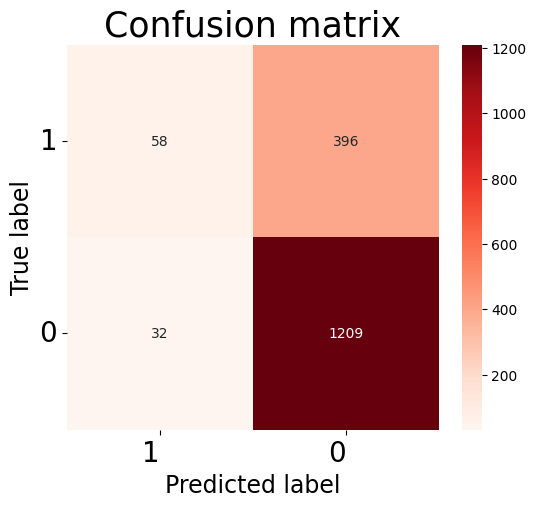

In [19]:
y_prob = model.predict_proba(x_test)[:,1]
y_label = model.predict(x_test)
evaluate_model(y_test, y_label, y_prob)

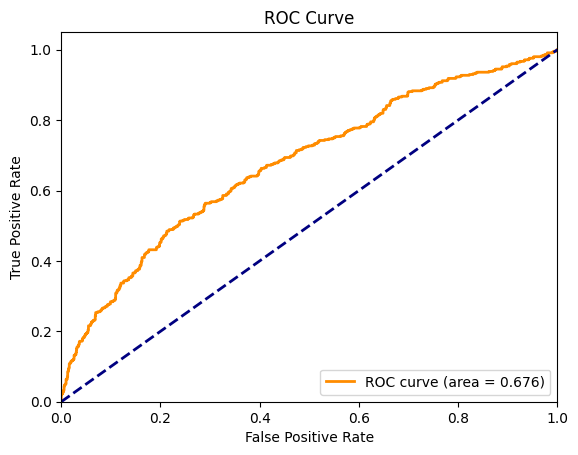

In [20]:
plot_roc(y_test, y_prob)